In [31]:
import os
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from scipy import stats

load_dotenv()

sql_username = os.getenv('db_username')
sql_password = os.getenv('db_password')
sql_host = os.getenv('db_hostname')
sql_database = os.getenv('db_database')

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"
TABLE = "research_experiment_refactor_test"

engine = create_engine(url_string)

SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Power(W)",
    "distance_total",
    "accel_load_accum",
    "leftMaxForce",
    "rightMaxForce"
]

sns.set(style="whitegrid")



In [32]:
TEAM_A = "Stony Brook Men's Basketball"
TEAM_B = "Stony Brook Women's Basketball"
METRIC_FOR_COMPARISON = "Jump Height(m)"

query = f"""
    SELECT playername, team, metric, value, timestamp
    FROM {TABLE}
    WHERE metric = '{METRIC_FOR_COMPARISON}'
      AND value IS NOT NULL
      AND team LIKE '%%Stony Brook%%'
"""

df_all = pd.read_sql(query, engine)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])

df_men = df_all[df_all["team"].str.contains("Stony Brook Men's Basketball", na=False)].copy()
df_women = df_all[df_all["team"].str.contains("Stony Brook Women's Basketball", na=False)].copy()

df_men["group"] = TEAM_A
df_women["group"] = TEAM_B

df_comp = pd.concat([df_men, df_women], ignore_index=True)
df_comp.head()


,playername,team,metric,value,timestamp,group
0,PLAYER_430,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.3115,2019-06-12 15:31:32,Stony Brook Men's Basketball
1,PLAYER_1167,"Group: Men's Basketball, Team: Stony Brook Men...",Jump Height(m),0.5271,2019-07-11 12:14:16,Stony Brook Men's Basketball
2,PLAYER_1167,"Group: Men's Basketball, Team: Stony Brook Men...",Jump Height(m),0.5668,2019-07-11 12:14:47,Stony Brook Men's Basketball
3,PLAYER_1208,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.4571,2019-07-11 12:15:28,Stony Brook Men's Basketball
4,PLAYER_1208,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.4490,2019-07-11 12:15:42,Stony Brook Men's Basketball


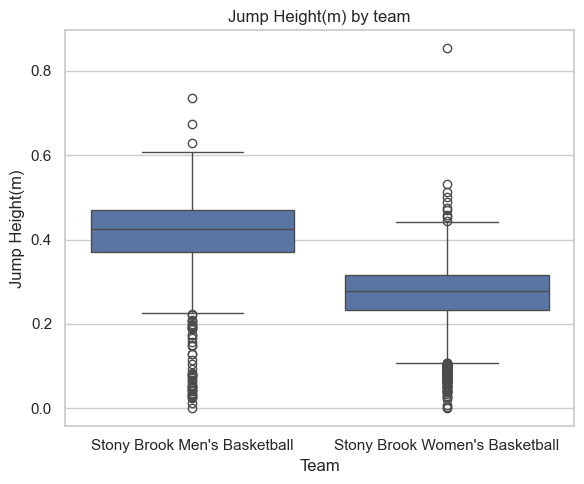

In [33]:
if not df_comp.empty:
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_comp, x="group", y="value")
    plt.title(f"{METRIC_FOR_COMPARISON} by team")
    plt.xlabel("Team")
    plt.ylabel(METRIC_FOR_COMPARISON)
    plt.tight_layout()
    plt.show()


In [34]:
# t-test
if (not df_men.empty) and (not df_women.empty):
    
    a_vals = df_men["value"].dropna().values
    b_vals = df_women["value"].dropna().values

    t_stat, p_val = stats.ttest_ind(a_vals, b_vals, equal_var=False)

    print("T-test for", METRIC_FOR_COMPARISON)
    print("t-statistic:", t_stat)
    print("p-value:", p_val)


T-test for Jump Height(m)
t-statistic: 76.42722555901663
p-value: 0.0


In [36]:
def clean_team_name(team):
    t = str(team)

    if "Men" in t and "Basketball" in t:
        return "Men's Basketball"
    if "Women" in t and "Basketball" in t:
        return "Women's Basketball"
    return None  # ignore all other teams


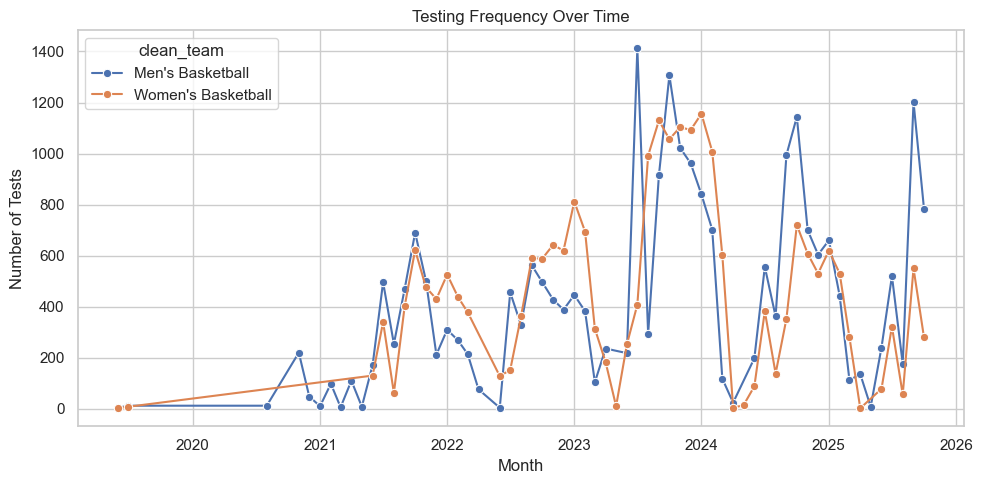

In [38]:
# analyze testing frequency over time for both teams
metrics_sql = "(" + ", ".join([f"'{m}'" for m in SELECTED_METRICS]) + ")"

query_freq = f"""
    SELECT team, timestamp
    FROM {TABLE}
    WHERE metric IN {metrics_sql}
      AND (team LIKE '%%Basketball%%')
"""

df_freq = pd.read_sql(query_freq, engine)

if not df_freq.empty:
    df_freq["timestamp"] = pd.to_datetime(df_freq["timestamp"])

    # clean messy team names
    df_freq["clean_team"] = df_freq["team"].apply(clean_team_name)
    df_freq = df_freq.dropna(subset=["clean_team"])

    # extract month
    df_freq["month"] = df_freq["timestamp"].dt.to_period("M").dt.to_timestamp()

    # count tests
    freq = (
        df_freq.groupby(["clean_team", "month"])
        .size()
        .reset_index(name="test_count")
    )

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=freq,
        x="month",
        y="test_count",
        hue="clean_team",
        marker="o"
    )
    plt.title("Testing Frequency Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Tests")
    plt.tight_layout()
    plt.show()

    freq.head()
else:
    print("No data found for testing frequency query.")


In [ ]:
# PART 3.3 – Quarterly Summary: Total Tests + Stacked Bars by Data Source

query_dash = f"""
    SELECT timestamp, data_source
    FROM {TABLE}
    WHERE timestamp IS NOT NULL
"""

df_dash = pd.read_sql(query_dash, engine)

df_dash["timestamp"] = pd.to_datetime(df_dash["timestamp"])
df_dash["quarter"] = df_dash["timestamp"].dt.to_period("Q").astype(str)

quarterly_by_source = (
    df_dash
    .groupby(["quarter", "data_source"])
    .size()
    .reset_index(name="test_count")
)

quarterly_pivot = (
    quarterly_by_source
    .pivot(index="quarter", columns="data_source", values="test_count")
    .fillna(0)
)

quarterly_pivot["total_tests"] = quarterly_pivot.sum(axis=1)

plt.figure(figsize=(12, 6))
quarterly_pivot.drop(columns=["total_tests"]).plot(
    kind="bar",
    stacked=True,
    ax=plt.gca(),
    colormap="tab20"
)

plt.title("Total Tests per Quarter by Data Source", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Number of Tests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
